In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import swan_vis as swan


p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
c_annot = '../cerberus_annot.h5'
ab = '../../talon/human_talon_abundance.tsv'
filt_ab = '../cerberus_filtered_abundance.tsv'
obs_col = 'sample'
min_tpm = 1
major_set = 'isos_sample_gene_90.tsv'
swan_file = 'swan.p'
mane_file = '/Users/fairliereese/mortazavi_lab/data/rnawg/refs/v40_gene_metadata.tsv'

In [3]:
def get_exp_gene_subset(ab, min_tpm, obs_col):
    df = pd.read_csv(ab, sep='\t')
    if obs_col == 'dataset':
        gb = 'library'
    else:
        gb = obs_col
    df = get_det_table(df,
                  groupby=gb,
                  how='gene',
                  min_tpm=min_tpm,
                  gene_subset='polya')

    df = df.melt(ignore_index=False, var_name='gid', value_name='detected').reset_index()
    df.rename({'library': 'dataset', 'biosample':'sample'}, axis=1, inplace=True)
    
    # limit to detected genes
    df = df.loc[df.detected==True]
    df.drop('detected', axis=1, inplace=True)
    
    fname = 'gids_{}_1_tpm.tsv'.format(obs_col)
    df.to_csv(fname, sep='\t', index=False)

In [4]:
# # save a file for library, gene id for detected polya genes
# get_exp_gene_subset(ab, min_tpm, obs_col='dataset')

In [5]:
# # save a file for sample, gene id for detected polya genes
# get_exp_gene_subset(ab, min_tpm, obs_col='sample')

In [6]:
def get_exp_mane_genes(obs_col):
    """
    Get list of genes that are expressed and have MANE isoforms
    """
    # get list of gene inds that are >=1 tpm and 
    # had a mane iso
    fname = 'gids_{}_1_tpm.tsv'.format(obs_col)
    df = pd.read_csv(fname, sep='\t')
    
    # genes w/ mane isoforms
    mane = pd.read_csv(mane_file, sep='\t')
    mane = mane.loc[mane.MANE_Select == True]
    mane['gid'] = cerberus.get_stable_gid(mane, col='gid')
    mane = mane.gid.tolist()    
    df = df.loc[df.gid.isin(mane)]
    

    # inds = list(set(inds)&(set(mane)))
    # print(len(inds))
    
    return df

In [7]:
# df = get_exp_mane_genes('dataset')

In [8]:
# df = get_exp_mane_genes('sample')

In [9]:
def compute_feat_tpm(adata, obs_col, feat, how, id_col, min_tpm=None):
    """
    Get TPM from SwanGraph for a given gene. Melt to long format.
    """
    tpm_df = swan.calc_tpm(adata, obs_col=obs_col, how=how)
    tpm_df = tpm_df.sparse.to_dense()
    tpm_df = tpm_df.T
    tpm_df = tpm_df.melt(var_name=obs_col, value_name='tpm', ignore_index=False)
    tpm_df.reset_index(inplace=True)
    tpm_df.rename({'index': id_col}, axis=1, inplace=True)
    
    # only expressed samples
    tpm_df = tpm_df.loc[tpm_df.tpm > 0]
    tpm_df = tpm_df.loc[~tpm_df.tpm.isnull()]
    
    # enforce additional expression thresh
    if min_tpm:
        tpm_df = tpm_df.loc[tpm_df.tpm >= min_tpm]
        
    tpm_df.rename({'tpm': '{}_tpm'.format(feat)}, axis=1, inplace=True)
    return tpm_df

In [10]:
def compute_feat_pi(adata, obs_col, t_df, feat):
    """
    Get Pi from SwanGraph for a given gene. Melt to long format.
    
        adata: adata, tss_adata, ic_adata, tes_adata
        t_df: t_df, tss_adata.var, ic_adata.var, tes_adata.var
        feat: {'triplet', 'tss', 'ic', 'tes'}
    """
    # get pi value for each feature in the specified gb category
    df, _ = swan.calc_pi(adata, t_df, obs_col=obs_col)
    df = df.sparse.to_dense()
    df = df.transpose()

    df = df.melt(var_name=obs_col, value_name='pi', ignore_index=False)
    df.reset_index(inplace=True)

    # only expressed samples
    df = df.loc[df.pi > 0]
    df = df.loc[~df.pi.isnull()]

    df.rename({'pi': '{}_pi'.format(feat)}, axis=1, inplace=True)

    return df

In [24]:
def get_principal_feats(df, feat, obs_col, id_col):
    """
    Get the most highly-expressed feature per gene / sample 
    """
    df = get_ranked_feats(df, feat, obs_col, id_col, rank=1)

    return df

def get_ranked_feats(df, feat, obs_col, id_col, rank):
    
    pi_col = '{}_tpm'.format(feat)
    tpm_col = '{}_pi'.format(feat)
    rank_col = '{}_rank'.format(feat)

    df = df.copy(deep=True)
    
    # sort by gene, sample, and pi value
    # dedupe across the gene and sample cols; take the top-expressed isoform
    df = df.sort_values(by=['gid', obs_col, tpm_col, pi_col],
                        ascending=[False, False, False, False])
    df[rank_col] = df.groupby(['gid', obs_col]).cumcount()+1
    df = df.loc[df[rank_col] == rank]
    return df

def get_mane_feats(ca, df, feat, obs_col, id_col, id_col_2):
    """
    Get the mane feature expressed per gene / sample
    """
    # get mane feature ids by looking at v40 metadata
    # then and cross referencing with how they were mapped w/ cerberus
    meta_df = pd.read_csv('../../../refs/v40_transcript_metadata.tsv', sep='\t')
    mane_tids = meta_df.loc[meta_df.MANE_Select].tid.tolist()
    mane_df = ca.t_map.copy(deep=True)
    mane_df = mane_df.loc[mane_df.source=='v40']
    mane_df = mane_df.loc[mane_df.original_transcript_id.isin(mane_tids)]
    mane_feats = mane_df[id_col_2].unique().tolist()
    
    df = df.copy(deep=True)
    df = df.loc[df[id_col].isin(mane_feats)]
    
    return df

In [99]:
def plot_tpms(temp, feat, how, x='mane', y='princ'):
        
    princ_col = f'{feat}_{how}_{y}'
    mane_col = f'{feat}_{how}_{x}'
    if how == 'tpm':
        princ_col_2 = f'log_{feat}_{how}_{y}'
        mane_col_2 = f'log_{feat}_{how}_{x}'
        temp[princ_col_2] = np.log2(temp[princ_col]+1)
        temp[mane_col_2] = np.log2(temp[mane_col]+1)
        princ_col = princ_col_2
        mane_col = mane_col_2
        
    lim_max = max(temp[princ_col].max(), temp[mane_col].max())
    xlim = ylim = (-2, lim_max)

    c_dict, order = get_feat_triplet_colors()  
    color = c_dict[feat]

    ax = sns.jointplot(data=temp, x=mane_col, y=princ_col, color=color, 
                       xlim=xlim, ylim=ylim, kind='hex')

    if feat == 'triplet':
        label = 'isoform'
    else:
        label = feat.upper()
        
    def get_hr_label(a):
        if a == 'mane':
            return 'MANE'
        elif a == 'princ':
            return 'Principal'
        elif a == 'sec':
            return 'Secondary'
        
    x_hr = get_hr_label(x)
    y_hr = get_hr_label(y)
    
    if how == 'tpm':
        # TODO change labels based on x and y
        ylabel = f'log2({y_hr} {label} TPM+1)'
        xlabel = f'log2({x_hr} {label} TPM+1)'
    elif how == 'pi':
        ylabel = f'{y_hr} isoform PI'
        xlabel = f'{x_hr} isoform PI'

    tick_range = range(0, int(lim_max+1), 5)
    ax.ax_joint.set_xticks(tick_range)
    ax.ax_joint.set_yticks(tick_range)
    ax.ax_joint.set(ylabel=ylabel, xlabel=xlabel)
    
    fname = f'figures/{x}_vs_{y}_{feat}_{how}.pdf'
    plt.savefig(fname, dpi=800, bbox_inches='tight')
    

In [13]:
def get_loopers(sg):
    """
    Get things to loop through when processing one feature at a time
    """
    feats = ['triplet', 'tss', 'ic', 'tes']
    adatas = [sg.adata, sg.tss_adata, sg.ic_adata, sg.tes_adata]
    t_dfs = [sg.t_df, sg.tss_adata.var, sg.ic_adata.var, sg.tes_adata.var]
    id_cols = {'triplet': 'tid', 'tss': 'tss_id', 'ic': 'ic_id', 'tes': 'tes_id'}
    id_cols_2 = {'triplet': 'transcript_id', 'tss': 'tss_id', 'ic': 'ic_id', 'tes': 'tes_id'}
    return feats, adatas, t_dfs, id_cols, id_cols_2


In [14]:
def get_pi_tpm(sg, adata, t_df, obs_col, feat, id_col, id_col_2, min_tpm_how=None, min_tpm=None):
    """
    Get long-form table w/ pi and tpm values for each feature
    """    
    tpm_df = compute_feat_tpm(adata, obs_col, feat, 'mean', id_col, min_tpm=min_tpm)
    pi_df = compute_feat_pi(adata, obs_col, t_df, feat)    
    df = tpm_df.merge(pi_df, how='left', on=[obs_col, id_col])
    
    # get gene id, gene name
    if feat == 'triplet':
        pat = '['
    else:
        pat = '_'
    df['gid'] = df[id_col].str.split(pat, expand=True)[0]
    g_df = sg.t_df[['gid', 'gname']].reset_index(drop=True).drop_duplicates()
    df = df.merge(g_df, how='left', on='gid')
    
    rank_col = '{}_rank'.format(feat)
    df[rank_col] = df.groupby(['gid', obs_col]).cumcount()+1
    
    return df

In [15]:
def get_pi_tpm_tables(sg, obs_col):
    feats, adatas, t_dfs, id_cols, id_cols_2 = get_loopers(sg)
    for feat, adata, t_df in zip(feats, adatas, t_dfs):

        # var init
        id_col = id_cols[feat]
        id_col_2 = id_cols_2[feat]
        t_df = t_df.copy(deep=True)

        # compute tpm and pi of each isoform
        df = get_pi_tpm(sg, adata, t_df, obs_col, feat, id_col, id_col_2)

        # save file
        fname = '{}_{}_pi_tpm.tsv'.format(feat, obs_col)
        df.to_csv(fname, sep='\t', index=False)

In [16]:
def plot_major_principal_feat_counts(df, feat, obs_col, opref='figures/', **kwargs):
    """
    Plot a histogram of the number of datasets where the major isoform
    is the principal isoform.
    
    Parameters:
        sg (swan_vis SwanGraph): SwanGraph with transcript
                abundance data added
    
    Returns:
        temp (pandas DataFrame): Output from `count_major_principal_feats`.
    """
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    sns.set_context('paper', font_scale=1.8)
    c_dict, order = get_feat_triplet_colors()  
    col = 'mp_perc'
    ax = sns.displot(data=df,
                     x=col,
                     linewidth=0, 
                     color=c_dict[feat],
                     binwidth=5,
                     alpha=1)
    ylabel = '# genes'
    if obs_col == 'dataset':
        label_col = 'librarie'
    else:
        label_col = obs_col
    if feat in ['tss', 'ic', 'tes']: 
        xlabel = '% of {}s where major {} is from MANE'.format(feat.upper(), obs_col)
    else:
        xlabel = '% of {}s where major isoform is MANE'.format(obs_col)

    ax.set(ylabel=ylabel, xlabel=xlabel)

    fname = '{}/mane_vs_principal_{}_{}_hist.pdf'.format(opref, feat, obs_col)
    plt.savefig(fname, dpi=800, bbox_inches='tight')

In [17]:
# # uncomment and run before running do_thing
# obs_col = 'dataset'
# exp_mane_genes = get_exp_mane_genes(obs_col)
# sg = swan.read(swan_file)
# ca = cerberus.read(c_annot)
# get_pi_tpm_tables(sg, obs_col)

In [18]:
# # uncomment and run before running do_thing
# obs_col = 'sample'
# exp_mane_genes = get_exp_mane_genes(obs_col)
# sg = swan.read(swan_file)
# ca = cerberus.read(c_annot)
# get_pi_tpm_tables(sg, obs_col)

In [19]:
# get_pi_tpm_tables(sg, obs_col)

In [20]:
sg = swan.read(swan_file)
ca = cerberus.read(c_annot)

Read in graph from swan.p


### Compare expression levels / pi from principal and mane

In [21]:
def do_thing(sg, obs_col, min_feat_tpm):
    feats, adatas, t_dfs, id_cols, id_cols_2 = get_loopers(sg)
    for feat, adata, t_df in zip(feats, adatas, t_dfs):

        # var init
        id_col = id_cols[feat]
        id_col_2 = id_cols_2[feat]
        t_df = t_df.copy(deep=True)

        # get pi / tpm table
        fname = '{}_{}_pi_tpm.tsv'.format(feat, obs_col)
        df = pd.read_csv(fname, sep='\t')

        # merge mane and principal; make sure that exp. of null genes == 0
        princ_df = get_principal_feats(df, feat, obs_col, id_col)
        sec_df = get_ranked_feats(df, feat, obs_col, id_col, rank=2)        
        mane_df = get_mane_feats(ca, df, feat, obs_col, id_col, id_col_2)
        mp_df = princ_df.merge(mane_df, how='left', on=['gid', 'gname', obs_col], suffixes=('_princ', '_mane'))
        mp_df['{}_tpm_mane'.format(feat)].fillna(0, inplace=True)

        # remove genes that don't have annotated, expressed MANE isoforms in this sample
        exp_mane_genes = get_exp_mane_genes(obs_col=obs_col)
        mp_df = mp_df.merge(exp_mane_genes, how='inner', on=['gid', obs_col])

        # threshold on tpm
        mp_df = mp_df.loc[mp_df['{}_tpm_princ'.format(feat)] >= min_feat_tpm] # exclude princ. isos < min
        mp_df.loc[mp_df['{}_tpm_mane'.format(feat)]<min_feat_tpm, '{}_tpm_mane'.format(feat)] = 0 # 0 out mane isos < min

        # is principal == mane?
        mp_col = '{}_princ_is_mane'.format(feat)
        mp_df[mp_col] = mp_df[id_col+'_princ'] == mp_df[id_col+'_mane']

        # histograms
        # count number of libraries / gene where mane == principal
        temp1 = mp_df[['gid', mp_col, obs_col]].groupby(['gid', mp_col]).count().reset_index()
        # count number of libraries / gene where the gene is actually expressed (and has an isoform >= 1 tpm)
        temp2 = temp1[['gid', obs_col]].groupby('gid').sum().reset_index()
        temp1.rename({obs_col: 'n_{}s'.format(obs_col)}, axis=1, inplace=True)
        temp2.rename({obs_col: 'n_{}s'.format(obs_col)}, axis=1, inplace=True)
        # merge total # expressed libraries w/ # libraries where mane == pricipal
        temp1 = temp1.merge(temp2, on='gid', suffixes=('_mp', ''))
        print('# genes: {}'.format(len(temp1.gid.unique().tolist())))
        # only get instances where mane == principal
        temp = temp1.loc[temp1[mp_col] == True].copy(deep=True)
        temp['mp_perc'] = (temp['n_{}s_mp'.format(obs_col)]/temp['n_{}s'.format(obs_col)])*100
        plot_major_principal_feat_counts(temp, feat, obs_col)

        # stats for principal != mane but mane still expressed
        temp = mp_df.loc[mp_df[mp_col] == False]
        n = len(temp.index)
        temp = temp.loc[temp['{}_tpm_mane'.format(feat)]>0]
        n_num = len(temp.index)
        print('{:.2f}% ({}/{}) of gene / {} combos have MANE expression where principal {} is not MANE '.format((n_num/n)*100, n_num, n, obs_col, feat))
        plot_tpms(temp, feat, 'tpm')
        plot_tpms(temp, feat, 'pi')
        
        temp['tpm_diff'] = temp['{}_tpm_princ'.format(feat)] - temp['{}_tpm_mane'.format(feat)]
        temp['log_tpm_diff'] = temp['log_{}_tpm_princ'.format(feat)] - temp['log_{}_tpm_mane'.format(feat)]
        sns.displot(data=temp, x='tpm_diff')
        sns.displot(data=temp, x='log_tpm_diff')
        
        # stats for principal != mane and mane NOT expressed
        temp = mp_df.loc[mp_df[mp_col] == False]
        n = len(temp.index)
        temp = temp.loc[temp['{}_tpm_mane'.format(feat)]==0]
        n_num = len(temp.index)
        print('{:.2f}% ({}/{}) of gene / {} combos have NO MANE expression where principal {} is not MANE '.format((n_num/n)*100, n_num, n, obs_col, feat))

        # what % of genes w/ mane isoforms that are expressed have >= 1 library where principal != mane
        n = len(mp_df.gid.unique().tolist())
        n_num = len(mp_df.loc[mp_df[mp_col]==False, 'gid'].unique().tolist())
        print('{:.2f}% ({}/{}) of genes have >= 1 {} where the principal {} is not MANE'.format((n_num/n)*100, n_num, n, obs_col, feat))

        # what % of genes w/ mane isoforms that are expressed have >= 1 library where principal == mane
        n = len(mp_df.gid.unique())
        n_num = len(mp_df.loc[mp_df[mp_col]==True, 'gid'].unique().tolist())
        print('{:.2f}% ({}/{}) of genes have >= 1 {} where the principal {} is MANE'.format((n_num/n)*100, n_num, n, obs_col, feat))
        print()    

In [22]:
# do_thing(sg, 'dataset', 0)

In [41]:
obs_col = 'dataset'
min_feat_tpm = 1
feats, adatas, t_dfs, id_cols, id_cols_2 = get_loopers(sg)
for feat, adata, t_df in zip(feats, adatas, t_dfs):

    # var init
    id_col = id_cols[feat]
    id_col_2 = id_cols_2[feat]
    t_df = t_df.copy(deep=True)

    # get pi / tpm table
    fname = '{}_{}_pi_tpm.tsv'.format(feat, obs_col)
    df = pd.read_csv(fname, sep='\t')

    # merge mane and principal; make sure that exp. of null genes == 0
    princ_df = get_principal_feats(df, feat, obs_col, id_col)
    sec_df = get_ranked_feats(df, feat, obs_col, id_col, rank=2) 
    rename_cols = ['tid', '{}_tpm'.format(feat), '{}_pi'.format(feat), '{}_rank'.format(feat)]
    rename_dict = dict([(c,'{}_sec'.format(c)) for c in rename_cols])
    sec_df.rename(rename_dict, axis=1, inplace=True)
    mane_df = get_mane_feats(ca, df, feat, obs_col, id_col, id_col_2)
    mp_df = princ_df.merge(mane_df, how='left', on=['gid', 'gname', obs_col], suffixes=('_princ', '_mane'))
    mp_df = mp_df.merge(sec_df, how='left', on=['gid', 'gname', obs_col], suffixes=('', '_sec'))
    mp_df['{}_tpm_mane'.format(feat)].fillna(0, inplace=True)
    mp_df['{}_tpm_sec'.format(feat)].fillna(0, inplace=True)
    
    # remove genes that don't have annotated, expressed MANE isoforms in this sample
    exp_mane_genes = get_exp_mane_genes(obs_col=obs_col)
    mp_df = mp_df.merge(exp_mane_genes, how='inner', on=['gid', obs_col])

    # threshold on tpm
    mp_df = mp_df.loc[mp_df['{}_tpm_princ'.format(feat)] >= min_feat_tpm] # exclude princ. isos < min
    mp_df.loc[mp_df['{}_tpm_mane'.format(feat)]<min_feat_tpm, '{}_tpm_mane'.format(feat)] = 0 # 0 out mane isos < min
    mp_df.loc[mp_df['{}_tpm_sec'.format(feat)]<min_feat_tpm, '{}_tpm_sec'.format(feat)] = 0 # 0 out sec isos < min

    # is principal == mane?
    mp_col = '{}_princ_is_mane'.format(feat)
    mp_df[mp_col] = mp_df[id_col+'_princ'] == mp_df[id_col+'_mane']
    
    # is secondary == mane?
    ms_col = '{}_sec_is_mane'.format(feat)
    mp_df[ms_col] = mp_df[id_col+'_sec'] == mp_df[id_col+'_sec']
    break
    
#     # histograms
#     # count number of libraries / gene where mane == principal
#     temp1 = mp_df[['gid', mp_col, obs_col]].groupby(['gid', mp_col]).count().reset_index()
#     # count number of libraries / gene where the gene is actually expressed (and has an isoform >= 1 tpm)
#     temp2 = temp1[['gid', obs_col]].groupby('gid').sum().reset_index()
#     temp1.rename({obs_col: 'n_{}s'.format(obs_col)}, axis=1, inplace=True)
#     temp2.rename({obs_col: 'n_{}s'.format(obs_col)}, axis=1, inplace=True)
#     # merge total # expressed libraries w/ # libraries where mane == pricipal
#     temp1 = temp1.merge(temp2, on='gid', suffixes=('_mp', ''))
#     print('# genes: {}'.format(len(temp1.gid.unique().tolist())))
#     # only get instances where mane == principal
#     temp = temp1.loc[temp1[mp_col] == True].copy(deep=True)
#     temp['mp_perc'] = (temp['n_{}s_mp'.format(obs_col)]/temp['n_{}s'.format(obs_col)])*100
#     plot_major_principal_feat_counts(temp, feat, obs_col)

#     # stats for principal != mane but mane still expressed
#     temp = mp_df.loc[mp_df[mp_col] == False]
#     n = len(temp.index)
#     temp = temp.loc[temp['{}_tpm_mane'.format(feat)]>0]
#     n_num = len(temp.index)
#     print('{:.2f}% ({}/{}) of gene / {} combos have MANE expression where principal {} is not MANE '.format((n_num/n)*100, n_num, n, obs_col, feat))
#     plot_tpms(temp, feat, 'tpm')
#     plot_tpms(temp, feat, 'pi')

#     temp['tpm_diff'] = temp['{}_tpm_princ'.format(feat)] - temp['{}_tpm_mane'.format(feat)]
#     temp['log_tpm_diff'] = temp['log_{}_tpm_princ'.format(feat)] - temp['log_{}_tpm_mane'.format(feat)]
#     sns.displot(data=temp, x='tpm_diff')
#     sns.displot(data=temp, x='log_tpm_diff')

#     # stats for principal != mane and mane NOT expressed
#     temp = mp_df.loc[mp_df[mp_col] == False]
#     n = len(temp.index)
#     temp = temp.loc[temp['{}_tpm_mane'.format(feat)]==0]
#     n_num = len(temp.index)
#     print('{:.2f}% ({}/{}) of gene / {} combos have NO MANE expression where principal {} is not MANE '.format((n_num/n)*100, n_num, n, obs_col, feat))

#     # what % of genes w/ mane isoforms that are expressed have >= 1 library where principal != mane
#     n = len(mp_df.gid.unique().tolist())
#     n_num = len(mp_df.loc[mp_df[mp_col]==False, 'gid'].unique().tolist())
#     print('{:.2f}% ({}/{}) of genes have >= 1 {} where the principal {} is not MANE'.format((n_num/n)*100, n_num, n, obs_col, feat))

#     # what % of genes w/ mane isoforms that are expressed have >= 1 library where principal == mane
#     n = len(mp_df.gid.unique())
#     n_num = len(mp_df.loc[mp_df[mp_col]==True, 'gid'].unique().tolist())
#     print('{:.2f}% ({}/{}) of genes have >= 1 {} where the principal {} is MANE'.format((n_num/n)*100, n_num, n, obs_col, feat))
#     print()    

In [43]:
mp_df.head()

,tid_princ,dataset,triplet_tpm_princ,triplet_pi_princ,gid,gname,triplet_rank_princ,tid_mane,triplet_tpm_mane,triplet_pi_mane,triplet_rank_mane,tid_sec,triplet_tpm_sec,triplet_pi_sec,triplet_rank_sec,triplet_princ_is_mane,triplet_sec_is_mane
0,"ENSG00000285043[5,15,1]",wtc11_1_3,243.411350,95.34883,ENSG00000285043,ENSG00000285043,1,"ENSG00000285043[1,1,1]",0.000000,0.357782,1.0,"ENSG00000285043[6,23,1]",3.196772,1.252236,2.0,False,True
1,"ENSG00000285043[5,15,1]",wtc11_1_2,407.012120,96.36363,ENSG00000285043,ENSG00000285043,1,"ENSG00000285043[1,1,1]",0.000000,0.227273,1.0,"ENSG00000285043[4,15,1]",5.759605,1.363636,2.0,False,True
2,"ENSG00000285043[5,15,1]",wtc11_1_1,209.457550,95.86563,ENSG00000285043,ENSG00000285043,1,"ENSG00000285043[1,1,1]",2.258303,1.033592,1.0,"ENSG00000285043[1,1,1]",2.258303,1.033592,2.0,False,True
3,"ENSG00000285043[5,15,1]",upper_lobe_of_right_lung_1_1,60.622135,86.15385,ENSG00000285043,ENSG00000285043,1,"ENSG00000285043[1,1,1]",2.165076,3.076923,1.0,"ENSG00000285043[6,25,1]",3.247614,4.615385,2.0,False,True
4,"ENSG00000285043[5,15,1]",right_ventricle_myocardium_superior_1_1,540.761660,96.95652,ENSG00000285043,ENSG00000285043,1,NaN,0.000000,NaN,NaN,"ENSG00000285043[6,21,1]",4.041567,0.724638,2.0,False,True


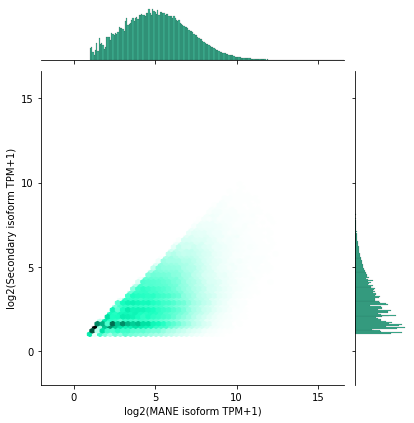

In [100]:
# plot secondary isoform tpm vs. mane when mane == principal
temp = mp_df.loc[(mp_df['{}_princ_is_mane'.format(feat)]==True)&(mp_df[f'{feat}_tpm_sec']>0)]
# temp['x'] = np.log2(temp[f'{feat}_tpm_mane']+1)
# temp['y'] = np.log2(temp[f'{feat}_tpm_sec']+1)

# ax = sns.jointplot(data=temp, x='x', y='y', size=2, alpha=0.3)

# ax = ax.ax_joint
# ax.set_xlabel('log2(TPM+1) of MANE isoform')
# ax.set_ylabel('log2(TPM+1) of secondary isoform')
plot_tpms(temp, feat, 'tpm', x='mane', y='sec')

In [ ]:
# plot mane vs. principal if mane != principal
# plot mane vs. secondary if mane == principal

In [91]:
temp = mp_df.loc[mp_df['{}_princ_is_mane'.format(feat)]==False] # first grab mane != principal
temp = pd.concat([temp, mp_df.loc[(mp_df['{}_princ_is_mane'.format(feat)]==True)&(mp_df['{}_tpm_sec'.format(feat)]>0)]]) # then grab mane == principal where there's a secondary


In [88]:
temp['y'] = np.nan
temp['y_source'] = np.nan
temp.loc[temp[f'{feat}_princ_is_mane']==True, 'y'] = temp.loc[temp[f'{feat}_princ_is_mane']==True, f'{feat}_tpm_sec']
temp.loc[temp[f'{feat}_princ_is_mane']==True, 'y_source'] = 'MANE == principal'

temp.loc[temp[f'{feat}_princ_is_mane']==False, 'y'] = temp.loc[temp[f'{feat}_princ_is_mane']==False, f'{feat}_tpm_princ']
temp.loc[temp[f'{feat}_princ_is_mane']==False, 'y_source'] = 'MANE != principal'

# remove null / 0
print(len(temp.index))
temp = temp.loc[temp[f'{feat}_tpm_mane']>0]
print(len(temp.index))
temp = temp.loc[~((temp[f'{feat}_princ_is_mane']!=True)&(temp['y']==0))]
print(len(temp.index))


temp['x'] = np.log2(temp[f'{feat}_tpm_mane']+1)
temp['y'] = np.log2(temp['y']+1)

1124756
656880
656880


Text(27.0, 0.5, 'log2(TPM+1) of primary or secondary isoform')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


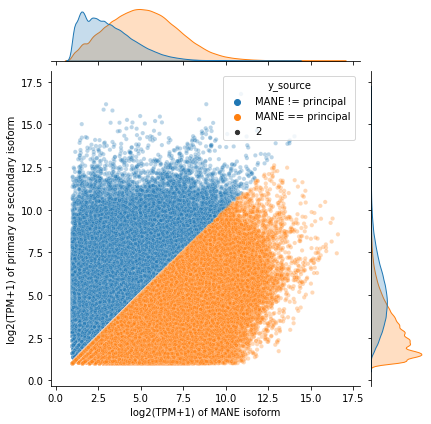

In [90]:
ax = sns.jointplot(data=temp, x='x', y='y', hue='y_source', size=2, alpha=0.3)

ax = ax.ax_joint
ax.set_xlabel('log2(TPM+1) of MANE isoform')
ax.set_ylabel('log2(TPM+1) of primary or secondary isoform')

In [54]:
do_thing(sg, 'dataset', 1)

In [24]:
# princ or secondary vs. mane
feats, adatas, t_dfs, id_cols, id_cols_2 = get_loopers(sg)
for feat, adata, t_df in zip(feats, adatas, t_dfs):

    # var init
    id_col = id_cols[feat]
    id_col_2 = id_cols_2[feat]
    t_df = t_df.copy(deep=True)

    # get pi / tpm table
    fname = '{}_{}_pi_tpm.tsv'.format(feat, obs_col)
    df = pd.read_csv(fname, sep='\t')

    # merge mane and principal; make sure that exp. of null genes == 0
    princ_df = get_principal_feats(df, feat, obs_col, id_col)
    sec_df = get_ranked_feats(df, feat, obs_col, id_col, rank=2)

In [25]:
sec_df.head()

,tes_id,sample,tes_tpm,tes_pi,gid,gname,tes_rank
96157,ENSG00000285991_2,mcf10a,2.830283,19.047619,ENSG00000285991,ENSG00000285991,2
246768,ENSG00000285991_3,hmec,2.527068,39.130436,ENSG00000285991,ENSG00000285991,2
395897,ENSG00000285988_1,pc9,0.840384,33.333336,ENSG00000285988,ENSG00000285988,2
806201,ENSG00000285988_1,calu3,0.459744,33.333336,ENSG00000285988,ENSG00000285988,2
672247,ENSG00000285976_3,wtc11,82.779526,42.564102,ENSG00000285976,ENSG00000285976,2


In [382]:
# do_thing(sg, 'sample', 1)

# genes: 16838
35.57% (265552/746618) of gene / dataset combos have MANE expression where principal triplet is not MANE 
64.43% (481066/746618) of gene / dataset combos have NO MANE expression where principal triplet is not MANE 
86.81% (14617/16838) of genes have >= 1 library where the principal triplet is not MANE
74.24% (12500/16838) of genes have >= 1 library where the principal triplet is MANE

# genes: 16838
34.46% (78144/226741) of gene / dataset combos have MANE expression where principal tss is not MANE 
65.54% (148597/226741) of gene / dataset combos have NO MANE expression where principal tss is not MANE 
57.87% (9744/16838) of genes have >= 1 library where the principal tss is not MANE
93.53% (15748/16838) of genes have >= 1 library where the principal tss is MANE

# genes: 16838
42.33% (150769/356136) of gene / dataset combos have MANE expression where principal ic is not MANE 
57.67% (205367/356136) of gene / dataset combos have NO MANE expression where principal ic is no

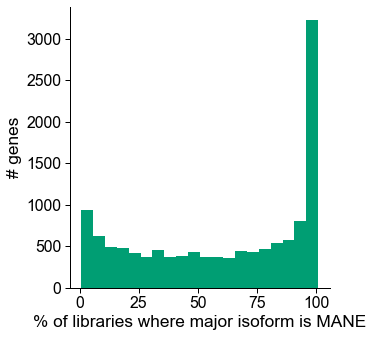

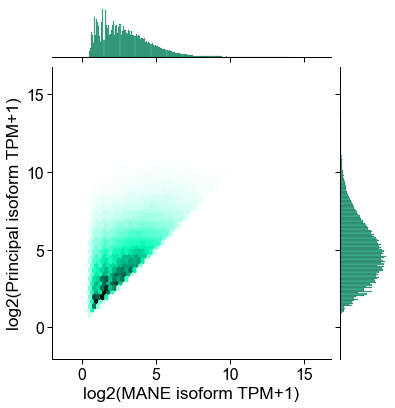

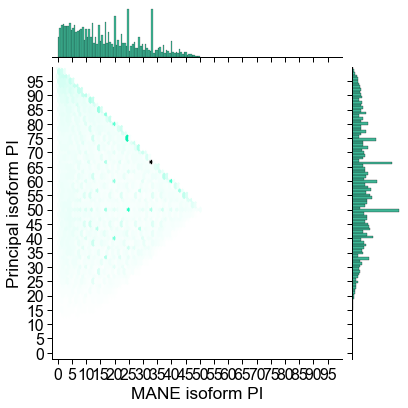

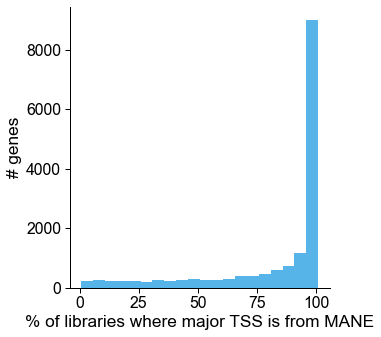

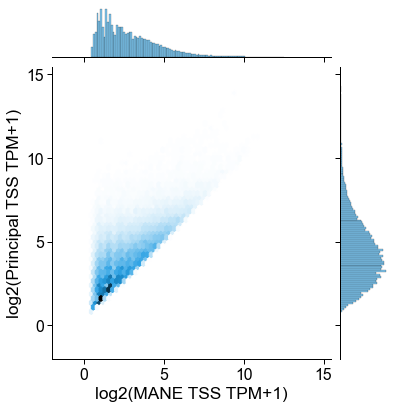

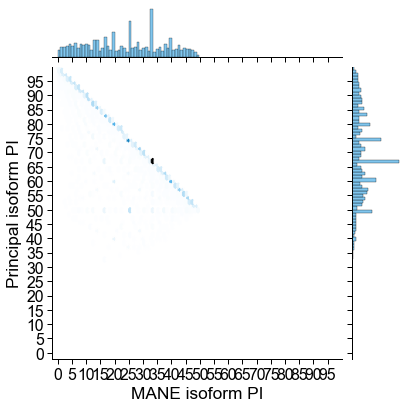

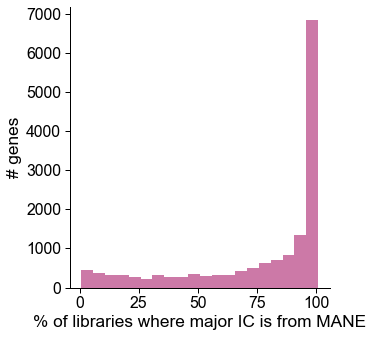

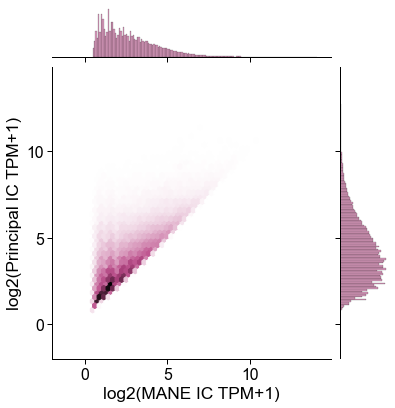

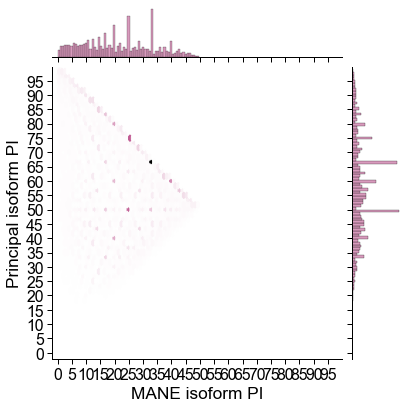

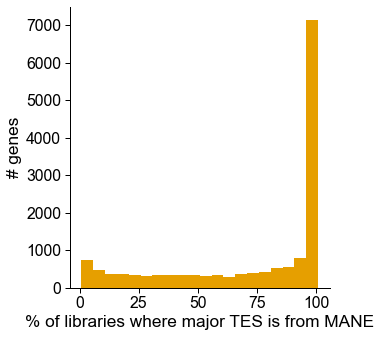

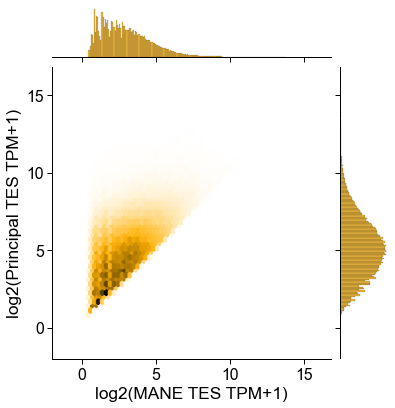

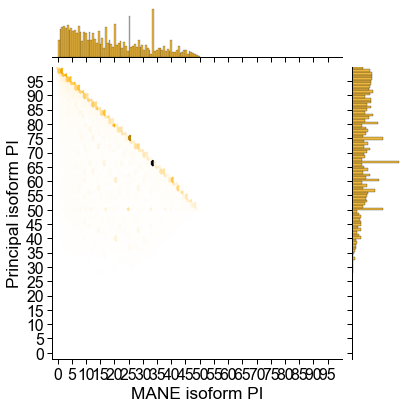

In [247]:
# get the major tss, ic, tes, and isoform from each sample
min_feat_tpm = 0
feats, adatas, t_dfs, id_cols, id_cols_2 = get_loopers(sg)
for feat, adata, t_df in zip(feats, adatas, t_dfs):

    # var init
    id_col = id_cols[feat]
    id_col_2 = id_cols_2[feat]
    t_df = t_df.copy(deep=True)
    
    # get pi / tpm table
    fname = '{}_{}_pi_tpm.tsv'.format(feat, obs_col)
    df = pd.read_csv(fname, sep='\t')

    # merge mane and principal; make sure that exp. of null genes == 0
    princ_df = get_principal_feats(df, feat, obs_col, id_col)
    mane_df = get_mane_feats(ca, df, feat, obs_col, id_col, id_col_2)
    mp_df = princ_df.merge(mane_df, how='left', on=['gid', 'gname', obs_col], suffixes=('_princ', '_mane'))
    mp_df['{}_tpm_mane'.format(feat)].fillna(0, inplace=True)

    # remove genes that don't have annotated, expressed MANE isoforms in this sample
    exp_mane_genes = get_exp_mane_genes()
    mp_df = mp_df.merge(exp_mane_genes, how='inner', on=['gid', 'dataset'])
    
    # threshold on tpm
    mp_df = mp_df.loc[mp_df['{}_tpm_princ'.format(feat)] >= min_feat_tpm] # exclude princ. isos < min
    mp_df.loc[mp_df['{}_tpm_mane'.format(feat)]<min_feat_tpm, '{}_tpm_mane'.format(feat)] = 0 # 0 out mane isos < min
    
    # is principal == mane?
    mp_col = '{}_princ_is_mane'.format(feat)
    mp_df[mp_col] = mp_df[id_col+'_princ'] == mp_df[id_col+'_mane']
    
    # histograms
    # count number of libraries / gene where mane == principal
    temp1 = mp_df[['gid', mp_col, obs_col]].groupby(['gid', mp_col]).count().reset_index()
    # count number of libraries / gene where the gene is actually expressed (and has an isoform >= 1 tpm)
    temp2 = temp1[['gid', obs_col]].groupby('gid').sum().reset_index()
    temp1.rename({obs_col: 'n_{}s'.format(obs_col)}, axis=1, inplace=True)
    temp2.rename({obs_col: 'n_{}s'.format(obs_col)}, axis=1, inplace=True)
    # merge total # expressed libraries w/ # libraries where mane == pricipal
    temp1 = temp1.merge(temp2, on='gid', suffixes=('_mp', ''))
    print('# genes: {}'.format(len(temp1.gid.unique().tolist())))
    # only get instances where mane == principal
    temp = temp1.loc[temp1[mp_col] == True].copy(deep=True)
    temp['mp_perc'] = (temp['n_{}s_mp'.format(obs_col)]/temp['n_{}s'.format(obs_col)])*100
    plot_major_principal_feat_counts(temp, feat)
    
    # stats for principal != mane but mane still expressed
    temp = mp_df.loc[mp_df[mp_col] == False]
    n = len(temp.index)
    temp = temp.loc[temp['{}_tpm_mane'.format(feat)]>0]
    n_num = len(temp.index)
    print('{:.2f}% ({}/{}) of gene / {} combos have MANE expression where principal {} is not MANE '.format((n_num/n)*100, n_num, n, obs_col, feat))
    plot_tpms(temp, feat, 'tpm')
    plot_tpms(temp, feat, 'pi')
    
    # stats for principal != mane and mane NOT expressed
    temp = mp_df.loc[mp_df[mp_col] == False]
    n = len(temp.index)
    temp = temp.loc[temp['{}_tpm_mane'.format(feat)]==0]
    n_num = len(temp.index)
    print('{:.2f}% ({}/{}) of gene / {} combos have NO MANE expression where principal {} is not MANE '.format((n_num/n)*100, n_num, n, obs_col, feat))
                                                                                                                       
    # what % of genes w/ mane isoforms that are expressed have >= 1 library where principal != mane
    n = len(mp_df.gid.unique().tolist())
    n_num = len(mp_df.loc[mp_df[mp_col]==False, 'gid'].unique().tolist())
    print('{:.2f}% ({}/{}) of genes have >= 1 library where the principal {} is not MANE'.format((n_num/n)*100, n_num, n, feat))
    
    # what % of genes w/ mane isoforms that are expressed have >= 1 library where principal == mane
    n = len(mp_df.gid.unique())
    n_num = len(mp_df.loc[mp_df[mp_col]==True, 'gid'].unique().tolist())
    print('{:.2f}% ({}/{}) of genes have >= 1 library where the principal {} is MANE'.format((n_num/n)*100, n_num, n, feat))
    print()    

In [224]:
# histogram plot
mp_df.head()

,tes_id_princ,dataset,tes_tpm_princ,tes_pi_princ,gid,gname,tes_id_mane,tes_tpm_mane,tes_pi_mane,tes_princ_is_mane
0,ENSG00000285043_1,wtc11_1_3,254.828380,99.821106,ENSG00000285043,ENSG00000285043,ENSG00000285043_1,254.828380,99.821106,True
1,ENSG00000285043_1,wtc11_1_2,421.411130,99.772730,ENSG00000285043,ENSG00000285043,ENSG00000285043_1,421.411130,99.772730,True
2,ENSG00000285043_1,wtc11_1_1,217.926200,99.741600,ENSG00000285043,ENSG00000285043,ENSG00000285043_1,217.926200,99.741600,True
3,ENSG00000285043_1,upper_lobe_of_right_lung_1_1,70.364975,100.000000,ENSG00000285043,ENSG00000285043,ENSG00000285043_1,70.364975,100.000000,True
4,ENSG00000285043_1,right_ventricle_myocardium_superior_1_1,557.736200,100.000000,ENSG00000285043,ENSG00000285043,ENSG00000285043_1,557.736200,100.000000,True


In [235]:
# count number of libraries / gene where mane == principal
temp1 = mp_df[['gid', mp_col, obs_col]].groupby(['gid', mp_col]).count().reset_index()

# count number of libraries / gene where the gene is actually expressed (and has an isoform >= 1 tpm)
temp2 = temp1[['gid', obs_col]].groupby('gid').sum().reset_index()
temp1.rename({obs_col: 'n_{}s'.format(obs_col)}, axis=1, inplace=True)
temp2.rename({obs_col: 'n_{}s'.format(obs_col)}, axis=1, inplace=True)

# merge total # expressed libraries w/ # libraries where mane == pricipal
temp1 = temp1.merge(temp2, on='gid', suffixes=('_mp', ''))
print('# genes: {}'.format(len(temp1.gid.unique().tolist())))

# only get instances where mane == principal
temp = temp1.loc[temp1[mp_col] == True].copy(deep=True)
temp['mp_perc'] = (temp['n_{}s_mp'.format(obs_col)]/temp['n_{}s'.format(obs_col)])*100

plot_major_principal_feat_counts(temp, feat)

25562
25562
# genes: 16710


,gid,tes_princ_is_mane,n_datasets_mp,n_datasets,mp_perc
1,ENSG00000000005,True,3,3,100.000000
3,ENSG00000000419,True,137,138,99.275362
5,ENSG00000000457,True,45,119,37.815126
7,ENSG00000000460,True,2,101,1.980198
9,ENSG00000000938,True,19,59,32.203390


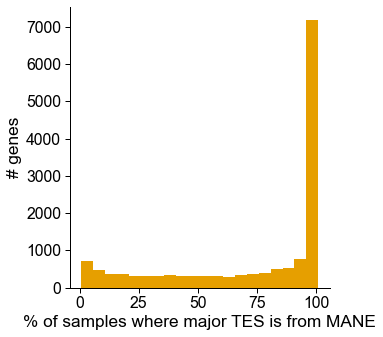

In [243]:
plot_major_principal_feat_counts(temp, feat)